In [17]:
import sys
sys.path.append('../../')

from pharynx_redox import (
    pharynx_io as pio, 
    image_processing as ip, 
    experiment, 
    plots, 
    profile_processing,
    data_analysis as da,
    utils
)

import xarray as xr
from pathlib import Path
from tqdm import tqdm_notebook
from scipy import signal
import seaborn as sns
from importlib import reload
import numpy as np
import logging
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.gofplots import qqplot

reload(logging)
reload(experiment)
reload(pio)
reload(ip)
reload(plots)
reload(profile_processing)
reload(da)
reload(utils)

# pd.set_option('display.height', 500)
pd.set_option('display.max_rows', 100)

logging.basicConfig(format='%(asctime)s %(levelname)s:%(message)s', level=logging.DEBUG, datefmt='%I:%M:%S')

In [32]:
mvmt = da.load_all_movement(Path('/Users/sean/code/pharynx_redox/data/paired_ratio/'))

In [3]:
prof_raw = da.load_all_cached_profile_data(Path('/Users/sean/code/pharynx_redox/data/paired_ratio/'), '**/*single_unreg/*.nc')
prof_reg = da.load_all_cached_profile_data(Path('/Users/sean/code/pharynx_redox/data/paired_ratio/'), '**/*matlab_reg/*-trimmed*.nc')

trimmed_regions = utils.scale_region_boundaries({
    "pm3": [0.07, 0.28],
    "pm4": [0.33, 0.45],
    "pm5": [0.53, 0.70],
    "pm6": [0.80, 0.86],
    "pm7": [0.88, 0.96],
}, prof_raw.shape[-1])

untrimmed_regions = utils.scale_region_boundaries({
    "pm3": [0.12, 0.30],
    "pm4": [0.35, 0.44],
    "pm5": [0.52, 0.65],
    "pm6": [0.73, 0.78],
    "pm7": [0.79, 0.85],
}, prof_raw.shape[-1])

err_prof_raw, err_tbl_raw = da.get_resid_rr(
    prof_raw, 
    summarize=True, 
    regions=trimmed_regions,
    value_name='error', 
    rescale=False
)
err_prof_reg, err_tbl_reg = da.get_resid_rr(
    prof_reg, 
    summarize=True, 
    regions=trimmed_regions,
    value_name='error', 
    rescale=False
)

err_tbl_raw['reg_strategy'] = 'raw'
err_tbl_reg['reg_strategy'] = 'reg'

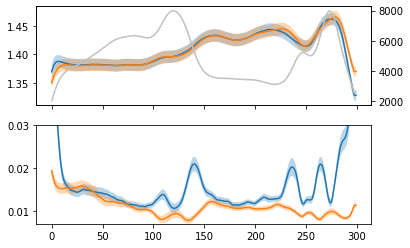

In [4]:
fig, axes = plt.subplots(2,1, sharex='all')

plots.plot_profile_avg_with_bounds(prof_raw.sel(wavelength='r', pair=0), label='raw', ax=axes[0])
plots.plot_profile_avg_with_bounds(prof_reg.sel(wavelength='r', pair=0), ax=axes[0], label='reg')

otherax = axes[0].twinx();
otherax.plot(prof_raw.sel(wavelength='470').mean(dim='pair').mean(dim='strain').T, color='silver');

plots.plot_profile_avg_with_bounds(err_prof_raw, ax=axes[1])
plots.plot_profile_avg_with_bounds(err_prof_reg, ax=axes[1])
axes[1].set_ylim(0.007,0.03);

# Find point of minimal mean error in RAW error profiles

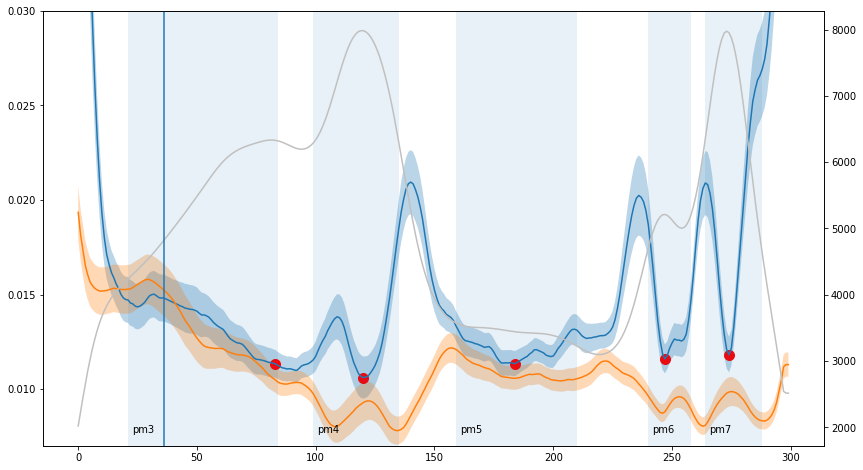

In [5]:
avg_error_raw = np.mean(err_prof_raw, axis=0).values

fig, ax = plt.subplots(figsize=(14,8))
plots.plot_profile_avg_with_bounds(err_prof_raw, ax=ax)
plots.plot_profile_avg_with_bounds(err_prof_reg, ax=ax)
ax.set_ylim(0.007,0.03);

otherax = ax.twinx();
otherax.plot(prof_raw.sel(wavelength='470').mean(dim='pair').mean(dim='strain').T, color='silver');

for _, region in trimmed_regions.items():
#     region = trimmed_regions['pm5']

    min_idx = np.argmin(avg_error_raw[region[0]:region[1]]) + region[0]


    ax.scatter(min_idx, avg_error_raw[min_idx], color='red', s=100, marker='o')
plots.add_regions_to_axis(ax, trimmed_regions)
plt.axvline(36)

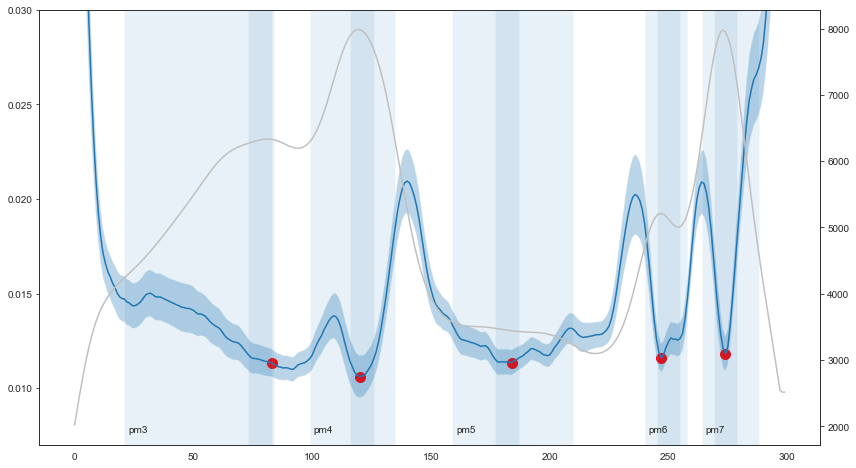

In [6]:
opt_regions = profile_processing.find_optimal_regions(
    trimmed_regions, 
    err_prof_raw, 
    rescale_regions=False,
    min_width=10
)

sns.set_style('white')
fig, ax = plt.subplots(figsize=(14,8))
plots.plot_profile_avg_with_bounds(err_prof_raw, ax=ax)
ax.set_ylim(0.007,0.03);

otherax = ax.twinx();
otherax.plot(prof_raw.sel(wavelength='470').mean(dim='pair').mean(dim='strain').T, color='silver');

for _, region in trimmed_regions.items():
    min_idx = np.argmin(avg_error_raw[region[0]:region[1]]) + region[0]

    ax.scatter(min_idx, avg_error_raw[min_idx], color='red', s=100, marker='o')
plots.add_regions_to_axis(ax, trimmed_regions)
plots.add_regions_to_axis(ax, opt_regions, hide_labels=True)
plt.savefig('/Users/sean/code/pharynx_redox/data/figures/optimized_regions_on_profile.pdf')

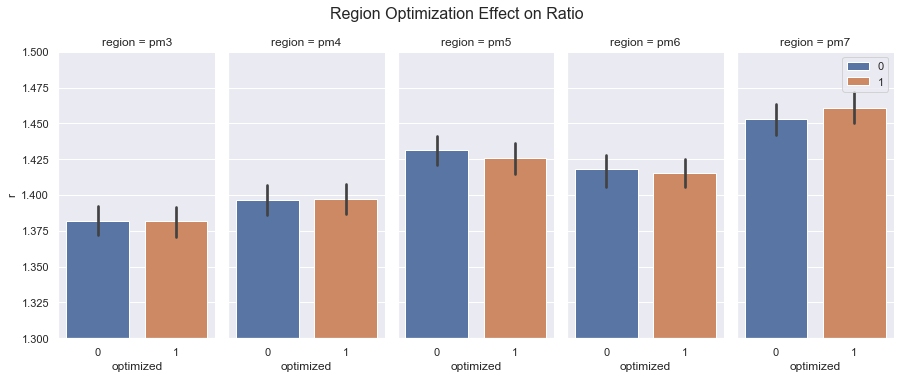

In [8]:
r_opt_regions = profile_processing.summarize_over_regions(prof_raw.sel(wavelength='r', pair=0), regions=opt_regions, rescale=False, value_name='r')
r_opt_regions['optimized'] = 1
r_raw_regions = profile_processing.summarize_over_regions(prof_raw.sel(wavelength='r', pair=0), regions=trimmed_regions, rescale=False, value_name='r')
r_raw_regions['optimized'] = 0

all_regions_r = pd.concat([r_opt_regions, r_raw_regions])

sns.set()
sns.catplot(
    x='optimized',
    hue='optimized',
    y='r',
    col='region',
    data=all_regions_r,
    kind='bar',
    dodge=False,
    aspect=0.5,
    legend_out=True,

).set(ylim=(1.3, 1.5))
plt.suptitle('Region Optimization Effect on Ratio', y=1.05, fontsize=16)
# plt.tight_layout()
plt.legend()
plt.savefig('/Users/sean/code/pharynx_redox/data/figures/opt_regions_r.pdf')
all_regions_r.to_csv('/Users/sean/code/pharynx_redox/data/figures/opt_regions_r.csv')

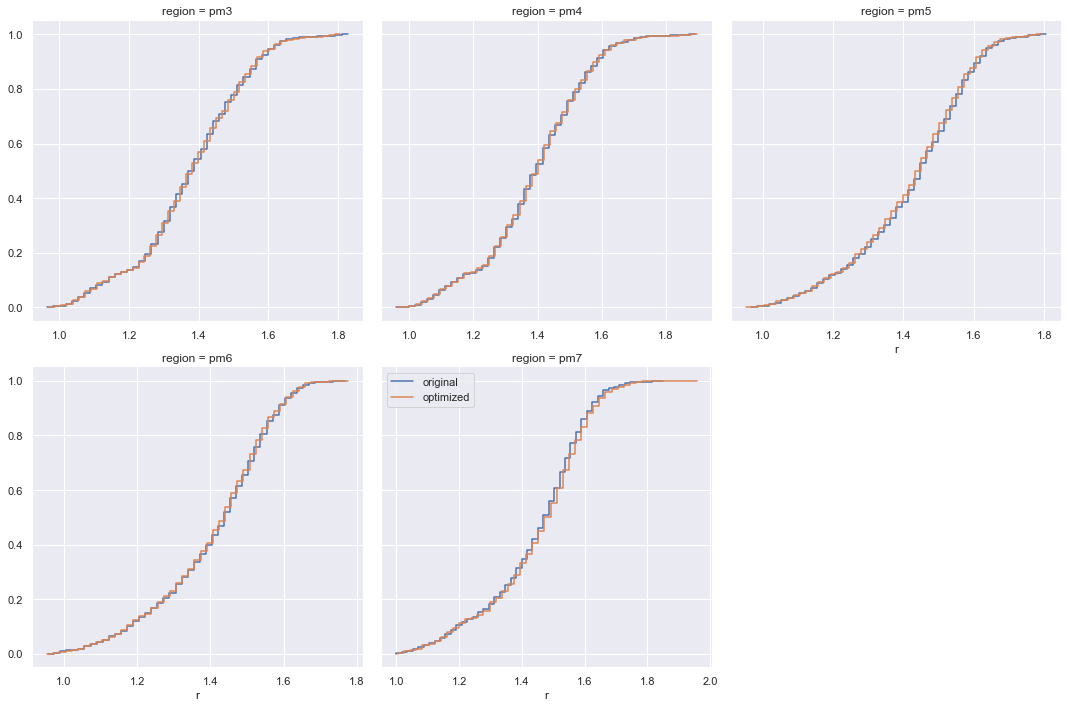

In [9]:
g = sns.FacetGrid(all_regions_r, col='region', hue='optimized', col_wrap=3, legend_out=True, height=5, aspect=1, sharex=False,)
g.map(plots.cdf_plot, 'r')
plt.legend(labels=('original', 'optimized'));
plt.savefig('/Users/sean/code/pharynx_redox/data/figures/opt_regions_R_CDF.pdf')

In [34]:
m_0_0, m_0_1, m_1_0, m_1_1 = da.split_by_movement_types(da.mvmt_long_to_wide(mvmt), 'posterior')

In [42]:
stationary_idx = m_0_0.reset_index().index.values
moving_idx = np.concatenate([m_0_1.reset_index().index.values, m_1_0.reset_index().index.values])

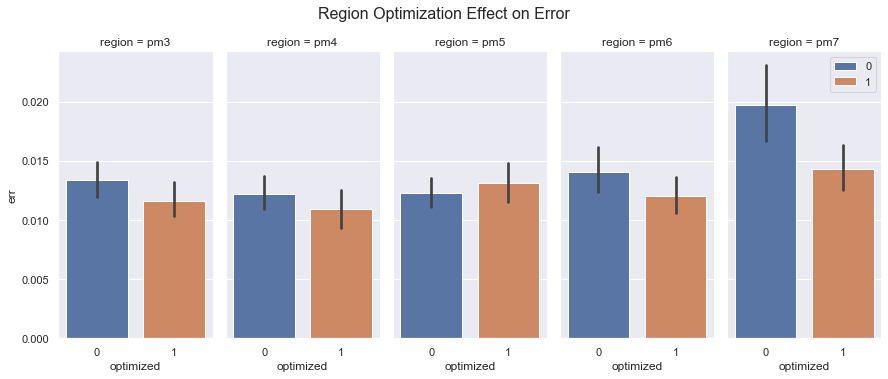

In [49]:
# CALCULATE
err_opt_regions = profile_processing.summarize_over_regions(err_prof_raw[moving_idx], regions=opt_regions, rescale=False, value_name='err')
err_opt_regions['optimized'] = 1
err_raw_regions = profile_processing.summarize_over_regions(err_prof_raw[moving_idx], regions=trimmed_regions, rescale=False, value_name='err')
err_raw_regions['optimized'] = 0

all_regions_err = pd.concat([err_opt_regions, err_raw_regions])
all_

# PLOT

sns.set()
sns.catplot(
    x='optimized',
    hue='optimized',
    y='err',
    col='region',
    data=all_regions_err,
    kind='bar',
    dodge=False,
    aspect=0.5,
    legend_out=True,

)
plt.suptitle('Region Optimization Effect on Error', y=1.05, fontsize=16)

# plt.tight_layout()
plt.legend();

# SAVE
plt.savefig('/Users/sean/code/pharynx_redox/data/figures/opt_regions_err.pdf')
all_regions_err.to_csv('/Users/sean/code/pharynx_redox/data/figures/opt_regions_err.csv')

In [59]:
all_regions_err

,err,region,animal,optimized,mvmt
0,0.014211,pm3,0,1,
1,0.017951,pm3,1,1,
2,0.011860,pm3,2,1,
3,0.007597,pm3,3,1,
4,0.013086,pm3,4,1,
5,0.015163,pm3,5,1,
6,0.004954,pm3,6,1,
7,0.009053,pm3,7,1,
8,0.042703,pm3,8,1,
9,0.000590,pm3,9,1,


In [72]:
all_regions_err[all_regions_err.animal.isin(stationary_idx)].mvmt = 'stationary'

0       
1       
2       
3       
4       
      ..
658     
659     
660     
661     
662     
Name: mvmt, Length: 6630, dtype: object

In [82]:
all_regions_err.reset_index()

,index,err,region,animal,optimized,mvmt
0,0,0.014211,pm3,0,1,
1,1,0.017951,pm3,1,1,
2,2,0.011860,pm3,2,1,
3,3,0.007597,pm3,3,1,
4,4,0.013086,pm3,4,1,
5,5,0.015163,pm3,5,1,
6,6,0.004954,pm3,6,1,
7,7,0.009053,pm3,7,1,
8,8,0.042703,pm3,8,1,
9,9,0.000590,pm3,9,1,


In [101]:
sidx = all_regions_err[all_regions_err.animal.isin(stationary_idx)].index.values
midx = all_regions_err[all_regions_err.animal.isin(moving_idx)].index.values

all_regions_err['mvmt'] = ''
all_regions_err.iloc[sidx, -1] = 'stationary'
all_regions_err.iloc[midx, -1] = 'moving'

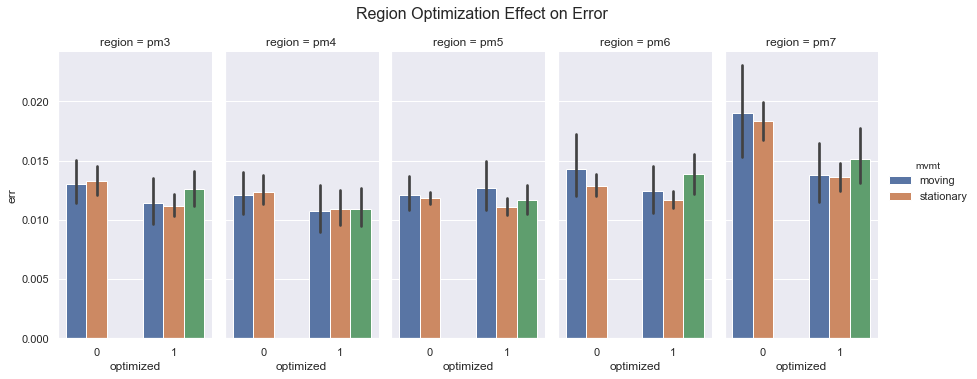

In [104]:
# CALCULATE
err_opt_regions = profile_processing.summarize_over_regions(err_prof_raw, regions=opt_regions, rescale=False, value_name='err')
err_opt_regions['optimized'] = 1
err_raw_regions = profile_processing.summarize_over_regions(err_prof_raw[stationary_idx], regions=trimmed_regions, rescale=False, value_name='err')
err_raw_regions['optimized'] = 0

all_regions_err = pd.concat([err_opt_regions, err_raw_regions]).reset_index()
sidx = all_regions_err[all_regions_err.animal.isin(stationary_idx)].index.values
midx = all_regions_err[all_regions_err.animal.isin(moving_idx)].index.values

all_regions_err['mvmt'] = ''
all_regions_err.iloc[sidx, -1] = 'stationary'
all_regions_err.iloc[midx, -1] = 'moving'

# PLOT

sns.set()
sns.catplot(
    x='optimized',
    hue='mvmt',
    y='err',
    col='region',
    data=all_regions_err,
    kind='bar',
    dodge=True,
    aspect=0.5,
    legend_out=True,

)
plt.suptitle('Region Optimization Effect on Error', y=1.05, fontsize=16)

# plt.tight_layout()
# plt.legend();

# SAVE
plt.savefig('/Users/sean/code/pharynx_redox/data/figures/opt_regions_err.pdf')
all_regions_err.to_csv('/Users/sean/code/pharynx_redox/data/figures/opt_regions_err.csv')

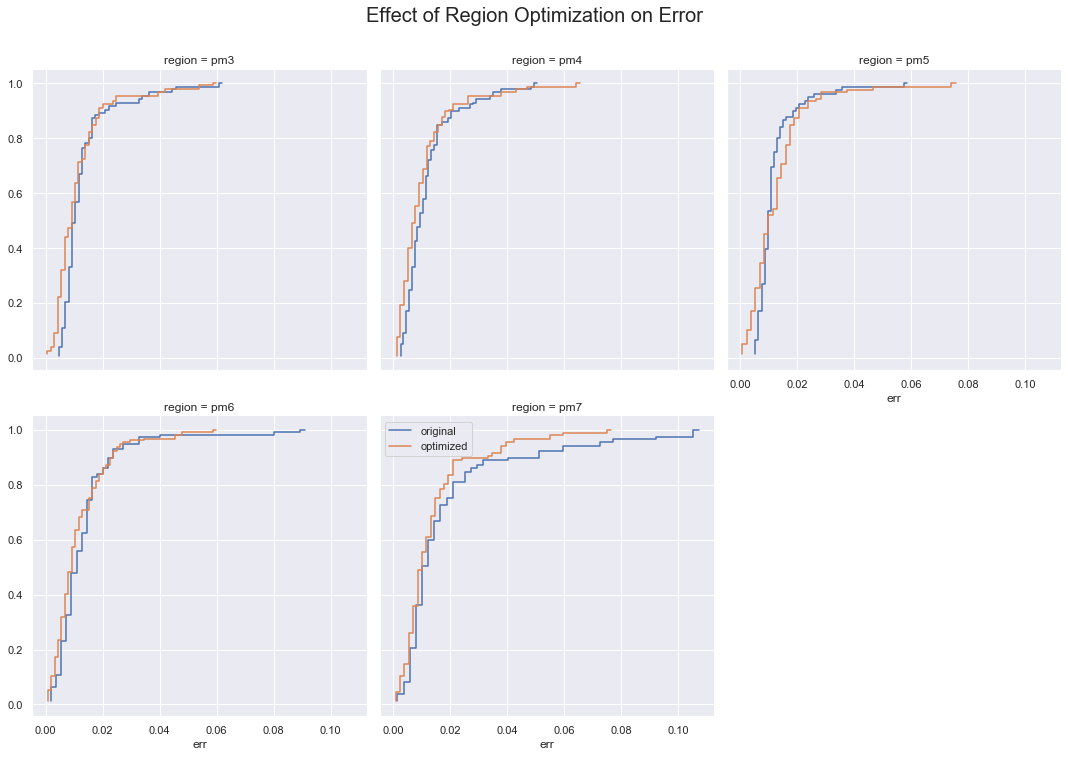

In [50]:
g = sns.FacetGrid(
    all_regions_err, 
    col='region',
    hue='optimized', 
    col_wrap=3,
    legend_out=True,
    height=5,
    aspect=1,
    sharex=True,
)
g.map(plots.cdf_plot, 'err')
plt.suptitle('Effect of Region Optimization on Error', y=1.05, fontsize=20);
plt.legend(labels=('original', 'optimized'));
plt.savefig('/Users/sean/code/pharynx_redox/data/figures/opt_regions_err_CDF.pdf');

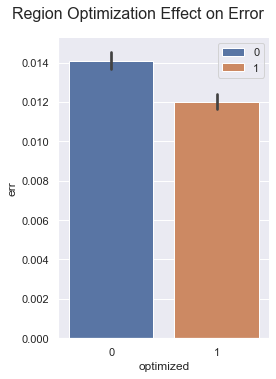

In [51]:
# CALCULATE
err_opt_regions = profile_processing.summarize_over_regions(err_prof_raw, regions=opt_regions, rescale=False, value_name='err')
err_opt_regions['optimized'] = 1
err_raw_regions = profile_processing.summarize_over_regions(err_prof_raw, regions=trimmed_regions, rescale=False, value_name='err')
err_raw_regions['optimized'] = 0

all_regions_err = pd.concat([err_opt_regions, err_raw_regions])

# PLOT

sns.set()
sns.catplot(
    x='optimized',
    hue='optimized',
    y='err',
    data=all_regions_err,
    kind='bar',
    dodge=False,
    aspect=0.8,
    legend_out=True,

)
plt.suptitle('Region Optimization Effect on Error', y=1.05, fontsize=16)

# plt.tight_layout()
plt.legend();

# SAVE
plt.savefig('/Users/sean/code/pharynx_redox/data/figures/opt_regions_err.pdf')
all_regions_err.to_csv('/Users/sean/code/pharynx_redox/data/figures/opt_regions_err.csv')